In [3]:
# Cisco Dacanay
#

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torchvision.models as models
import kagglehub
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [4]:
# Function to seperate 
def separate_dataset(dataset):
    # Initialize lists to hold data and labels
    data_list = []
    label_list = []

    # Iterate through each tuple in the dataset
    for data_tensor, label_tensor in dataset:
        # Convert tensors to NumPy arrays and append to the respective lists
        data_list.append(data_tensor.cpu().numpy())  # Move to CPU if needed
        label_list.append(label_tensor.cpu().numpy())

    # Convert lists to NumPy arrays
    data_array = np.array(data_list)
    label_array = np.array(label_list)

    return data_array, label_array

In [5]:
train_set = torch.load("./Datasets/train_set.pt")
val_set = torch.load("./Datasets/val_set.pt")
test_set = torch.load("./Datasets/test_set.pt")

C:\Users\darth\AppData\Local\Temp\ipykernel_30596\3295831271.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load("./Datasets/train_set.pt")
C:\Users\d

In [6]:
# Extract data
train_features, train_labels = separate_dataset(train_set)
val_features, val_labels = separate_dataset(val_set)
test_features, test_labels = separate_dataset(test_set)

# Create DMatrix objects for XGBoost
train_data = xgb.DMatrix(train_features, label=train_labels)
val_data = xgb.DMatrix(val_features, label=val_labels)

In [ ]:
# Define XGBoost parameters
params = {
    "objective": "reg:squarederror",  # For regression; use "binary:logistic" for binary classification
    "tree_method": "hist",       
    "device": "cuda",    # Use GPU for predictions
    "learning_rate": 0.1,
    "max_depth": 6,
    "eval_metric": ["rmse", "mae"]            # Metric to monitor; can add more (e.g., "mae")
}

# Define evaluation sets
evals = [(train_data, "train"), (val_data, "validation")]

# Train the model and capture evaluation results
evals_result = {}
xgb_model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=100,             # Number of boosting rounds
    evals=evals,                     # Evaluation sets
    evals_result=evals_result,       # To store evaluation metrics
    early_stopping_rounds=10,        # Stop if no improvement in 10 rounds
    verbose_eval=1                   # Print evaluation metrics at each round
)

[0]	train-rmse:85.31583	train-mae:41.48080	validation-rmse:84.35430	validation-mae:40.03436
[1]	train-rmse:78.20222	train-mae:37.54803	validation-rmse:77.86721	validation-mae:36.30933
[2]	train-rmse:71.75485	train-mae:33.94629	validation-rmse:72.44919	validation-mae:33.02785
[3]	train-rmse:65.91033	train-mae:30.74436	validation-rmse:67.18852	validation-mae:30.02255
[4]	train-rmse:60.61650	train-mae:27.85416	validation-rmse:62.27913	validation-mae:27.28701
[5]	train-rmse:55.78435	train-mae:25.24780	validation-rmse:57.49646	validation-mae:24.84195
[6]	train-rmse:51.37506	train-mae:22.89809	validation-rmse:53.13227	validation-mae:22.65215
[7]	train-rmse:47.37634	train-mae:20.75996	validation-rmse:49.43063	validation-mae:20.65370
[8]	train-rmse:43.69360	train-mae:18.84154	validation-rmse:45.75966	validation-mae:18.91330
[9]	train-rmse:40.32847	train-mae:17.10980	validation-rmse:42.35452	validation-mae:17.30588
[10]	train-rmse:37.24601	train-mae:15.55601	validation-rmse:39.93923	validation-

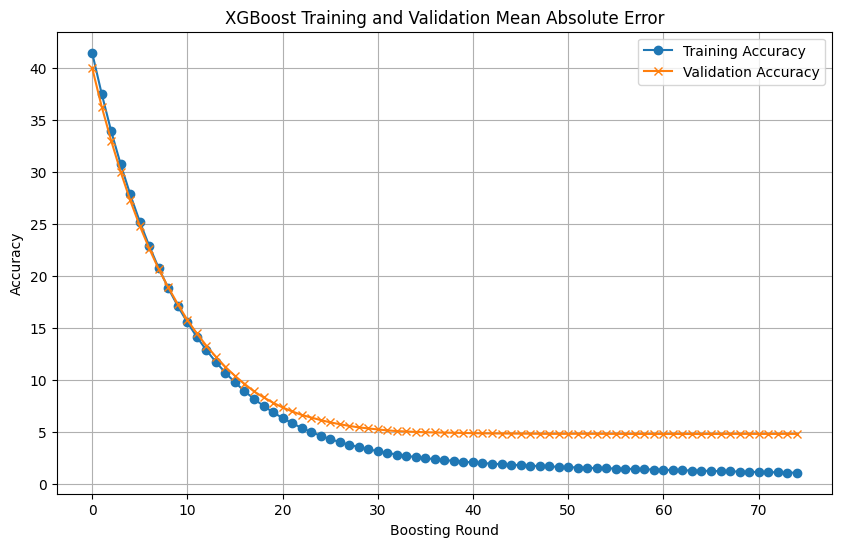

In [14]:
# Plot training and validation loss and accuracy over boosting rounds
train_logloss = evals_result["train"]["rmse"]
val_logloss = evals_result["validation"]["rmse"]
train_accuracy = evals_result["train"]["mae"]  # XGBoost reports error rate for accuracy
val_accuracy = evals_result["validation"]["mae"]

plt.figure(figsize=(10, 6))
'''
# Plot Loss
#plt.subplot(1, 2, 1)
plt.plot(train_logloss, label="Training Log Loss", marker='o')
plt.plot(val_logloss, label="Validation Log Loss", marker='x')
plt.xlabel("Boosting Round")
plt.ylabel("Mean Squared Error")
plt.title("XGBoost Training and Validation Root Mean Squared Error")
plt.legend()
plt.grid(True)
'''
# Plot Accuracy

#plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Training Accuracy", marker='o')
plt.plot(val_accuracy, label="Validation Accuracy", marker='x')
plt.xlabel("Boosting Round")
plt.ylabel("Accuracy")
plt.title("XGBoost Training and Validation Mean Absolute Error")
plt.legend()
plt.grid(True)

#plt.tight_layout()
plt.show()

In [9]:
# Prepare test data
test_data = xgb.DMatrix(test_features)

# Predict using the trained model
test_predictions = xgb_model.predict(test_data)


mse = mean_squared_error(test_labels, test_predictions)
print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test Root MSE: {math.sqrt(mse):.4f}")

Test Mean Squared Error: 38.2050
Test Root MSE: 6.1810


In [10]:
# Print predictions for each test sample
print("Predictions for test samples:")
for i, (prediction, label) in enumerate(zip(test_predictions, test_labels)):
    print(f"Sample {i + 1}: ")
    print(f"Prediction = {prediction:.4f}")
    print(f"Actual     = {label:.4f}")

Predictions for test samples:
Sample 1: 
Prediction = 50.6928
Actual     = 49.2700
Sample 2: 
Prediction = 29.6851
Actual     = 31.8500
Sample 3: 
Prediction = 88.0181
Actual     = 85.1100
Sample 4: 
Prediction = 54.7192
Actual     = 52.0000
Sample 5: 
Prediction = 30.7091
Actual     = 34.5250
Sample 6: 
Prediction = 88.7218
Actual     = 81.8000
Sample 7: 
Prediction = 121.3878
Actual     = 122.4600
Sample 8: 
Prediction = 27.6538
Actual     = 27.6525
Sample 9: 
Prediction = 73.8607
Actual     = 72.6500
Sample 10: 
Prediction = 43.8391
Actual     = 45.2100
Sample 11: 
Prediction = 44.0466
Actual     = 44.9100
Sample 12: 
Prediction = 23.0212
Actual     = 23.7700
Sample 13: 
Prediction = 39.1890
Actual     = 37.6700
Sample 14: 
Prediction = 129.2174
Actual     = 121.3600
Sample 15: 
Prediction = 48.6894
Actual     = 49.4100
Sample 16: 
Prediction = 343.5690
Actual     = 339.4500
Sample 17: 
Prediction = 28.5055
Actual     = 24.6600
Sample 18: 
Prediction = 45.6699
Actual     = 47.4200
S

In [11]:
# Save the model
#xgb_model.save_model("./Models/xgb_model.json")